<a href="https://colab.research.google.com/github/NatJiana/NextGenDev/blob/main/CancellationPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import seaborn as sns
import joblib

In [80]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cancellation Models/Reservations.csv')
df_org = df.copy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
pd.set_option('display.max_columns', None)
display(df.head())
print(f"Dataset Rows:{df.shape[0]}")
print(f"Dataset Columns:{df.shape[1]}\n\n")
print(f"Missing Values:\n{df.isnull().sum()}")

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


Dataset Rows:36275
Dataset Columns:19


Missing Values:
Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64


Let's create a new feature by combining the 'arrival_year', 'arrival_month', and 'arrival_date' columns into a single datetime feature. This can help the model capture temporal patterns.

In [82]:
display(df.describe())


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000



Booking status distribution:
booking_status
Not_Canceled    0.672364
Canceled        0.327636
Name: proportion, dtype: float64


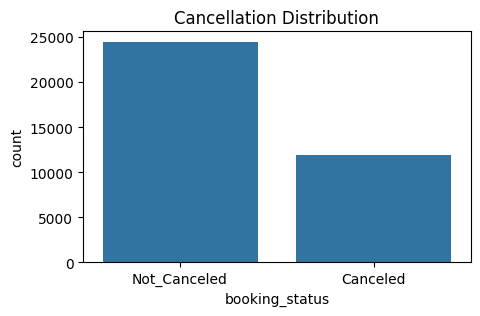

In [83]:
# Check target variable distribution
print("\nBooking status distribution:")
print(df['booking_status'].value_counts(normalize=True))


plt.figure(figsize=(5,3))
sns.countplot(x= 'booking_status', data=df, order=['Not_Canceled','Canceled'])
plt.title('Cancellation Distribution')
plt.show()

In [84]:

# Handling categorical values

dfEncoded = pd.get_dummies(df, columns=['type_of_meal_plan','room_type_reserved', 'market_segment_type'])
dfEncoded['encoded_booking_status'] = dfEncoded['booking_status'].apply(lambda x: 1 if x == 'Not_Canceled' else 0)



Split training Data and target Variable

In [85]:
from sklearn.model_selection import train_test_split

features = dfEncoded.drop(['encoded_booking_status', 'booking_status', 'Booking_ID'], axis=1)
target = dfEncoded['encoded_booking_status']

# Use stratified splitting to ensure class distribution is maintained
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

Training The Gradient Boosting Model

In [86]:
#Initialise
gb_clf = GradientBoostingClassifier(n_estimators=200, learning_rate= 0.1, max_depth=2, random_state=42)

#Train model
gb_clf.fit(X_train, y_train)

#Predict
y_pred_gb = gb_clf.predict(X_test)



Gradient Boosting Classifier Model Evaluation

AUC Score: 0.9108587783395714
Accuracy: 0.8489317711922811

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.71      0.76      2377
           1       0.87      0.92      0.89      4878

    accuracy                           0.85      7255
   macro avg       0.84      0.81      0.82      7255
weighted avg       0.85      0.85      0.85      7255



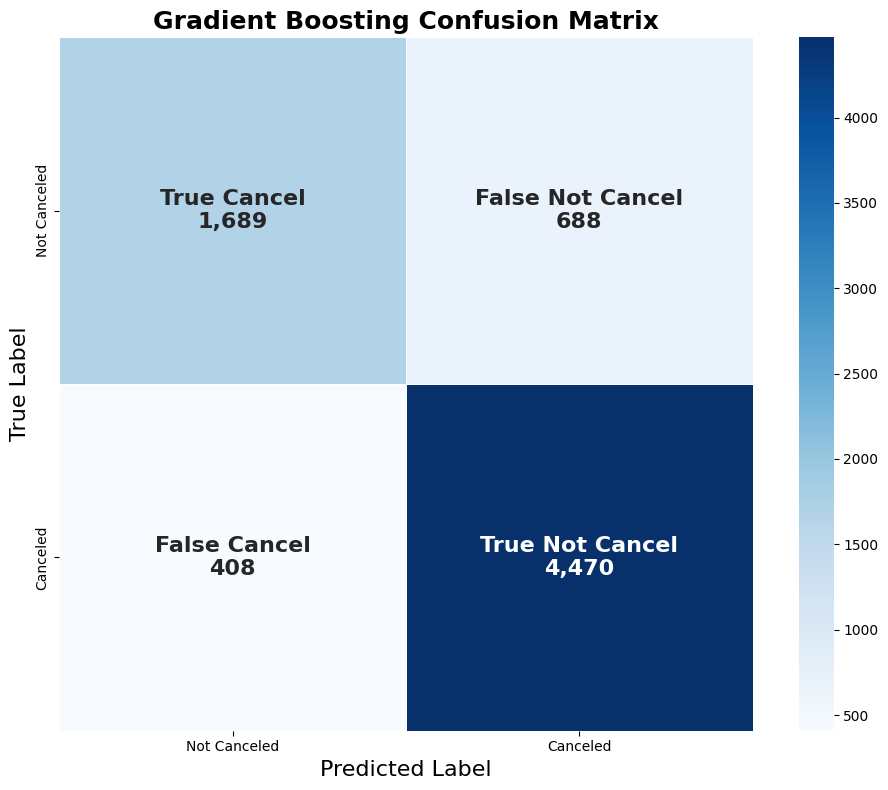

In [87]:
# Calculate AUC score
auc_gb = roc_auc_score(y_test, gb_clf.predict_proba(X_test)[:, 1])
print("AUC Score:", auc_gb)
# Calculate Accuracy
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Accuracy:", accuracy_gb)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))

# Plot Confusion Matrix for Gradient Boosting
cm_gb = confusion_matrix(y_test, y_pred_gb)
group_names = ['True Cancel', 'False Not Cancel', 'False Cancel', 'True Not Cancel']
group_counts = [f"{value:,}" for value in cm_gb.flatten()]
labels = [f"{name}\n{count}" for name, count in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)

fig, axes = plt.subplots(1, 1, figsize=(10, 8))

sns.heatmap(
    cm_gb, annot=labels, fmt='', cmap='Blues',
    xticklabels=['Not Canceled', 'Canceled'],
    yticklabels=['Not Canceled', 'Canceled'],
    linewidths=0.5, linecolor='white', square=True, cbar=True,
    annot_kws={"size": 16, "weight": "bold"}, ax=axes
)
axes.set_xlabel('Predicted Label', fontsize=16)
axes.set_ylabel('True Label', fontsize=16)
axes.set_title('Gradient Boosting Confusion Matrix', fontsize=18, weight='bold')

plt.tight_layout()
plt.show()

Training and Evaluating the Random Forest Classifier on the original data.

In [88]:
# Initialize the Random Forest Classifier
rf_clf = RandomForestClassifier( n_estimators= 100, max_depth= None, min_samples_leaf = 2, random_state= 42, class_weight = 'balanced')

# Train the model using the original training data
rf_clf.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = rf_clf.predict(X_test)

Random Forest Accuracy: 0.9048931771192281

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      2377
           1       0.92      0.93      0.93      4878

    accuracy                           0.90      7255
   macro avg       0.89      0.89      0.89      7255
weighted avg       0.90      0.90      0.90      7255

Random Forest AUC Score: 0.9577557786516022


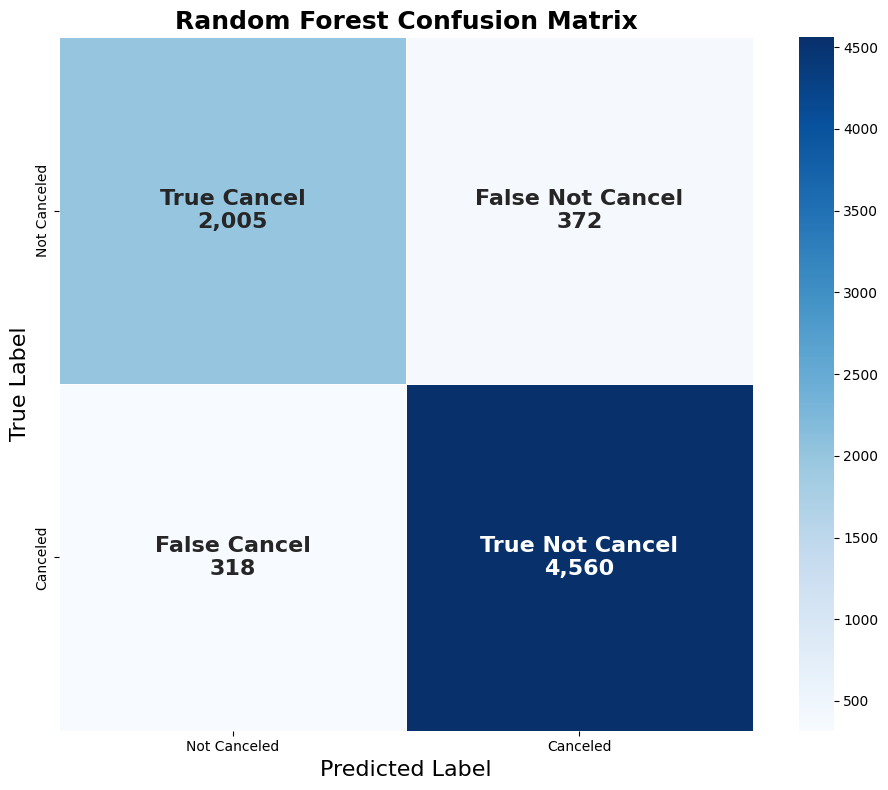

In [89]:
# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

auc_rf = roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1])
print("Random Forest AUC Score:", auc_rf)

# Plot Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
group_names = ['True Cancel', 'False Not Cancel', 'False Cancel', 'True Not Cancel']
group_counts = [f"{value:,}" for value in cm_rf.flatten()]
labels = [f"{name}\n{count}" for name, count in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)

fig, axes = plt.subplots(1, 1, figsize=(10, 8))

sns.heatmap(
    cm_rf, annot=labels, fmt='', cmap='Blues',
    xticklabels=['Not Canceled', 'Canceled'],
    yticklabels=['Not Canceled', 'Canceled'],
    linewidths=0.5, linecolor='white', square=True, cbar=True,
    annot_kws={"size": 16, "weight": "bold"}, ax=axes
)
axes.set_xlabel('Predicted Label', fontsize=16)
axes.set_ylabel('True Label', fontsize=16)
axes.set_title('Random Forest Confusion Matrix', fontsize=18, weight='bold')

plt.tight_layout()
plt.show()

Random Forest with Parameter Tunning

In [90]:
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

random_search = GridSearchCV(
    estimator = rf_clf,
    param_grid = param_grid,
    scoring = 'accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
    )

random_search.fit(features, target)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100]},
             scoring='accuracy', verbose=1)

Random Forest Classifier with Parameter Tuning Evaluation


Best Parameters Found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.9015024121295658

Gradient Boosting(With Tunning) Accuracy: 0.9943487250172295

Gradient Boosting(With Tunning) Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2377
           1       0.99      1.00      1.00      4878

    accuracy                           0.99      7255
   macro avg       0.99      0.99      0.99      7255
weighted avg       0.99      0.99      0.99      7255



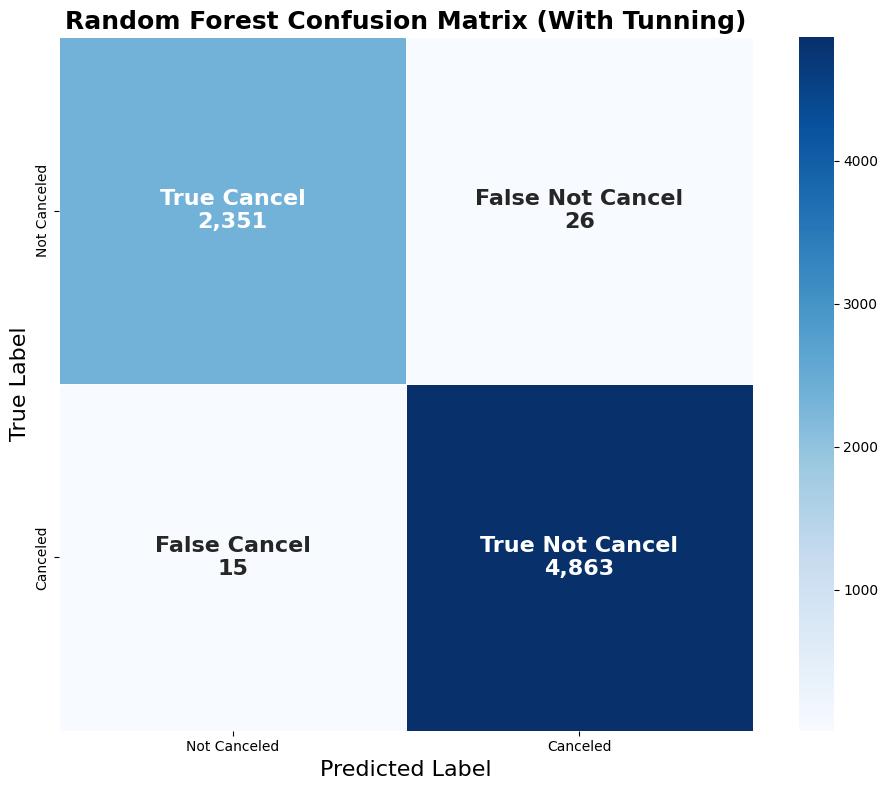

In [91]:

print("\nBest Parameters Found:", random_search.best_params_)
print("Best Cross-Validation Accuracy:", random_search.best_score_)


best_model = random_search.best_estimator_
y_predGrid = best_model.predict(X_test)

print("\nGradient Boosting(With Tunning) Accuracy:", accuracy_score(y_test, y_predGrid))
print("\nGradient Boosting(With Tunning) Classification Report:\n", classification_report(y_test, y_predGrid))
#

# Plot Confusion Matrix for Random Forest(With Tunning)
cm_rfGrid = confusion_matrix(y_test, y_predGrid)
group_names = ['True Cancel', 'False Not Cancel', 'False Cancel', 'True Not Cancel']
group_counts = [f"{value:,}" for value in cm_rfGrid.flatten()]
labels = [f"{name}\n{count}" for name, count in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)

fig, axes = plt.subplots(1, 1, figsize=(10, 8))

sns.heatmap(
    cm_rfGrid, annot=labels, fmt='', cmap='Blues',
    xticklabels=['Not Canceled', 'Canceled'],
    yticklabels=['Not Canceled', 'Canceled'],
    linewidths=0.5, linecolor='white', square=True, cbar=True,
    annot_kws={"size": 16, "weight": "bold"}, ax=axes
)
axes.set_xlabel('Predicted Label', fontsize=16)
axes.set_ylabel('True Label', fontsize=16)
axes.set_title('Random Forest Confusion Matrix (With Tunning)', fontsize=18, weight='bold')

plt.tight_layout()
plt.show()

Save Trained Models

In [92]:
import joblib
import os
from google.colab import files, drive



# Define the target directory in Google Drive
drive_dir = '/content/drive/MyDrive/Colab Notebooks/Cancellation Models'

os.makedirs(drive_dir, exist_ok=True)

# Saving the Trained Gradient Boosting Model

#Saving the Trained Random Forest Model
rf_model_filename = os.path.join(drive_dir, 'random_forest_model.joblib')
joblib.dump(rf_clf, rf_model_filename)
print(f"Trained Random Forest model saved to: {rf_model_filename}")

#Saving the Best Model from Randomized Search
gb_model_filename = os.path.join(drive_dir, 'gradient_boosting_model.joblib')
joblib.dump(gb_clf, gb_model_filename)
print(f"Trained Gradient Boosting model saved to: {gb_model_filename}")

# Saving the Tuned Random Forest Model

best_model_filename = os.path.join(drive_dir, 'tuned_random_forest_model.joblib')
if 'best_model' in locals(): # Check if best_model variable exists
    joblib.dump(best_model, best_model_filename)
    print(f"Tuned Random Forest model saved to: {best_model_filename}")
else:
    print("Error: 'best_model' not found. Please run the RandomizedSearchCV cell first.")


# Downloading the Saved Models
print("\nDownloading the saved models...")
try:
    files.download(rf_model_filename)
    files.download(gb_model_filename)
    if 'best_model' in locals():
        files.download(best_model_filename)
except Exception as e:
    print(f"An error occurred during download: {e}")

Trained Random Forest model saved to: /content/drive/MyDrive/Colab Notebooks/Cancellation Models/random_forest_model.joblib
Trained Gradient Boosting model saved to: /content/drive/MyDrive/Colab Notebooks/Cancellation Models/gradient_boosting_model.joblib
Tuned Random Forest model saved to: /content/drive/MyDrive/Colab Notebooks/Cancellation Models/tuned_random_forest_model.joblib



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest model loaded successfully from: /content/drive/MyDrive/Colab Notebooks/Cancellation Models/random_forest_model.joblib
Loaded Random Forest model refitted successfully.

--- Loaded Random Forest Model Evaluation ---
Accuracy: 0.9086147484493453

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.82      0.86      2377
           1       0.92      0.95      0.93      4878

    accuracy                           0.91      7255
   macro avg       0.90      0.89      0.89      7255
weighted avg       0.91      0.91      0.91      7255

AUC Score: 0.9575429283952075


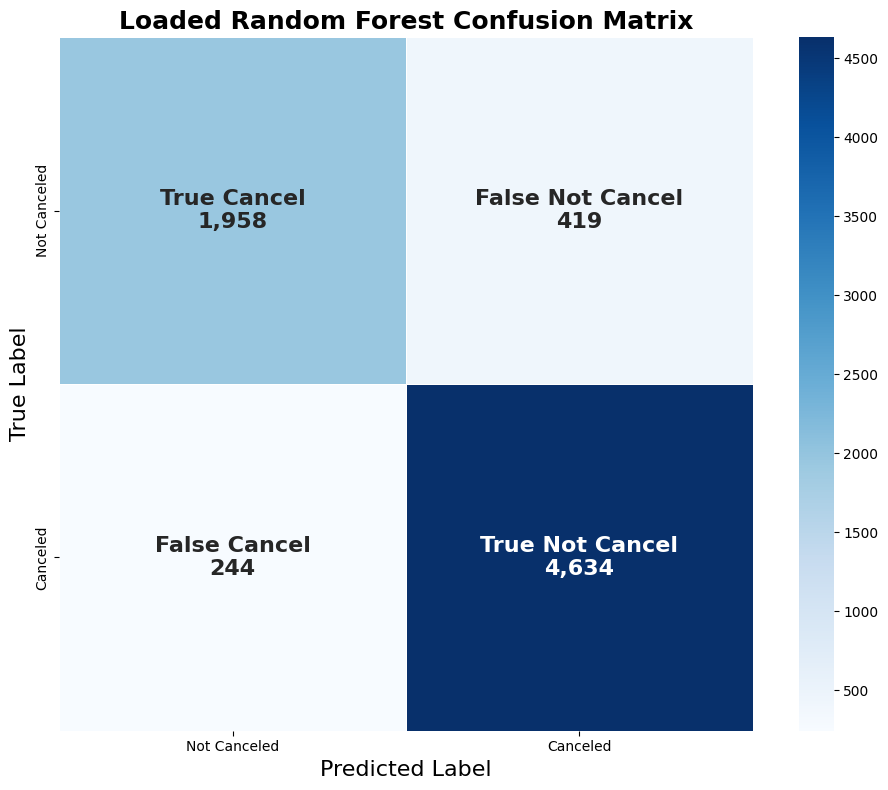

--------------------------------------------------
Gradient Boosting model loaded successfully from: /content/drive/MyDrive/Colab Notebooks/Cancellation Models/gradient_boosting_model.joblib

--- Loaded Gradient Boosting Model Evaluation ---
Accuracy: 0.8489317711922811

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.71      0.76      2377
           1       0.87      0.92      0.89      4878

    accuracy                           0.85      7255
   macro avg       0.84      0.81      0.82      7255
weighted avg       0.85      0.85      0.85      7255

AUC Score: 0.9108587783395714


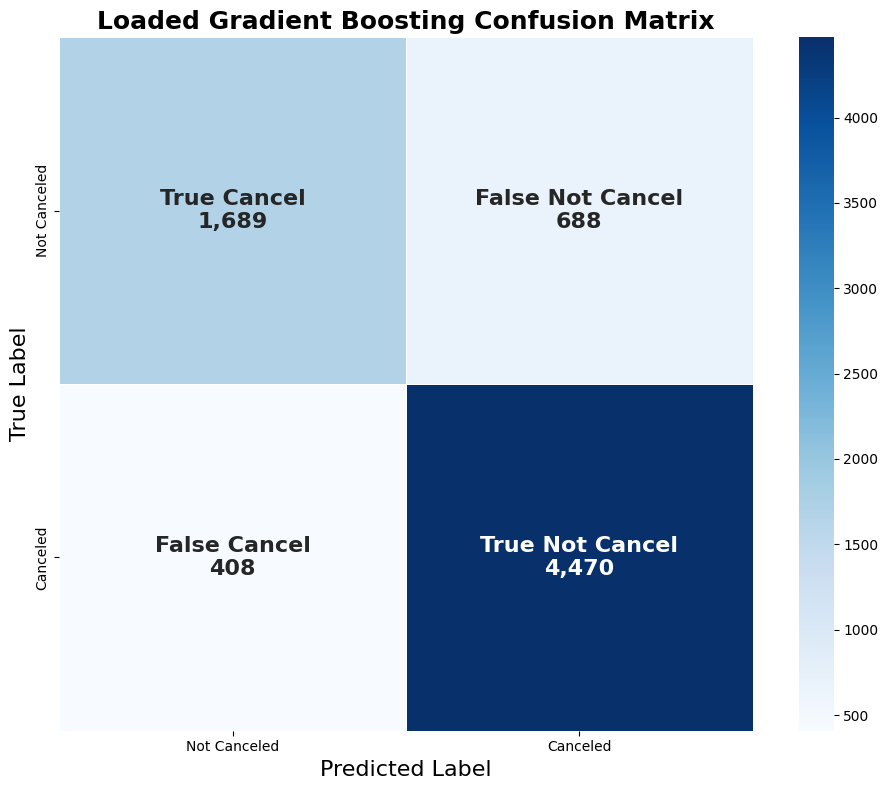

--------------------------------------------------
Tuned Random Forest model loaded successfully from: /content/drive/MyDrive/Colab Notebooks/Cancellation Models/tuned_random_forest_model.joblib
Loaded Tuned Random Forest model refitted successfully.

--- Loaded Tuned Random Forest Model Evaluation ---
Accuracy: 0.9943487250172295

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2377
           1       0.99      1.00      1.00      4878

    accuracy                           0.99      7255
   macro avg       0.99      0.99      0.99      7255
weighted avg       0.99      0.99      0.99      7255

AUC Score: 0.9993721434900509


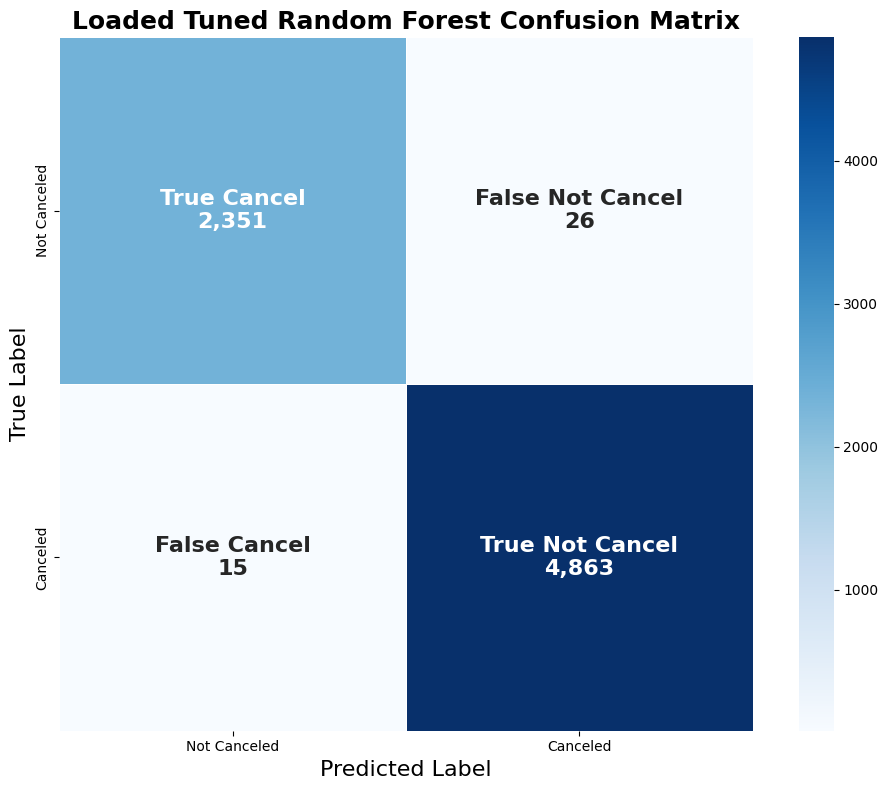

In [93]:
import joblib
import os
from google.colab import drive
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Mount Google Drive if not already mounted
# drive.mount('/content/drive') # Uncomment and run if your Drive is not mounted

# Define the directory where models are saved
drive_dir = '/content/drive/MyDrive/Colab Notebooks/Cancellation Models'

# --- Loading and Evaluating the Trained Random Forest Model ---
rf_model_filename = os.path.join(drive_dir, 'random_forest_model.joblib')
if os.path.exists(rf_model_filename):
    loaded_rf_model = joblib.load(rf_model_filename)
    print(f"Random Forest model loaded successfully from: {rf_model_filename}")

    # **Refit the loaded model as a workaround for NotFittedError**
    # Note: Ideally, this should not be necessary if the model was saved correctly after fitting.
    # However, as a workaround for the NotFittedError, we refit the model here.
    # Ensure X_train and y_train are available in the environment.
    try:
        loaded_rf_model.fit(X_train, y_train)
        print("Loaded Random Forest model refitted successfully.")
    except NameError:
        print("Error: X_train or y_train not found. Cannot refit the loaded model.")
        loaded_rf_model = None # Set to None to skip evaluation if refitting fails


    if loaded_rf_model:
      # Predict and evaluate
      y_pred_loaded_rf = loaded_rf_model.predict(X_test)
      print("\n--- Loaded Random Forest Model Evaluation ---")
      print("Accuracy:", accuracy_score(y_test, y_pred_loaded_rf))
      print("\nClassification Report:\n", classification_report(y_test, y_pred_loaded_rf))
      print("AUC Score:", roc_auc_score(y_test, loaded_rf_model.predict_proba(X_test)[:, 1]))

      # Plot Confusion Matrix
      cm_loaded_rf = confusion_matrix(y_test, y_pred_loaded_rf)
      group_names = ['True Cancel', 'False Not Cancel', 'False Cancel', 'True Not Cancel']
      group_counts = [f"{value:,}" for value in cm_loaded_rf.flatten()]
      labels = [f"{name}\n{count}" for name, count in zip(group_names, group_counts)]
      labels = np.asarray(labels).reshape(2, 2)
      fig, axes = plt.subplots(1, 1, figsize=(10, 8))
      sns.heatmap(cm_loaded_rf, annot=labels, fmt='', cmap='Blues', xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'], linewidths=0.5, linecolor='white', square=True, cbar=True, annot_kws={"size": 16, "weight": "bold"}, ax=axes)
      axes.set_xlabel('Predicted Label', fontsize=16)
      axes.set_ylabel('True Label', fontsize=16)
      axes.set_title('Loaded Random Forest Confusion Matrix', fontsize=18, weight='bold')
      plt.tight_layout()
      plt.show()

else:
    print(f"Random Forest model file not found at: {rf_model_filename}")

print("-" * 50) # Separator

# --- Loading and Evaluating the Trained Gradient Boosting Model ---
gb_model_filename = os.path.join(drive_dir, 'gradient_boosting_model.joblib')
if os.path.exists(gb_model_filename):
    loaded_gb_model = joblib.load(gb_model_filename)
    print(f"Gradient Boosting model loaded successfully from: {gb_model_filename}")

    # Predict and evaluate
    y_pred_loaded_gb = loaded_gb_model.predict(X_test)
    print("\n--- Loaded Gradient Boosting Model Evaluation ---")
    print("Accuracy:", accuracy_score(y_test, y_pred_loaded_gb))
    print("\nClassification Report:\n", classification_report(y_test, y_pred_loaded_gb))
    print("AUC Score:", roc_auc_score(y_test, loaded_gb_model.predict_proba(X_test)[:, 1]))

    # Plot Confusion Matrix
    cm_loaded_gb = confusion_matrix(y_test, y_pred_loaded_gb)
    group_names = ['True Cancel', 'False Not Cancel', 'False Cancel', 'True Not Cancel']
    group_counts = [f"{value:,}" for value in cm_loaded_gb.flatten()]
    labels = [f"{name}\n{count}" for name, count in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    fig, axes = plt.subplots(1, 1, figsize=(10, 8))
    sns.heatmap(cm_loaded_gb, annot=labels, fmt='', cmap='Blues', xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'], linewidths=0.5, linecolor='white', square=True, cbar=True, annot_kws={"size": 16, "weight": "bold"}, ax=axes)
    axes.set_xlabel('Predicted Label', fontsize=16)
    axes.set_ylabel('True Label', fontsize=16)
    axes.set_title('Loaded Gradient Boosting Confusion Matrix', fontsize=18, weight='bold')
    plt.tight_layout()
    plt.show()

else:
     print(f"Gradient Boosting model file not found at: {gb_model_filename}")

print("-" * 50) # Separator

#Loading and Evaluating the Tuned Random Forest Model
tuned_rf_model_filename = os.path.join(drive_dir, 'tuned_random_forest_model.joblib')
if os.path.exists(tuned_rf_model_filename):
    loaded_tuned_rf_model = joblib.load(tuned_rf_model_filename)
    print(f"Tuned Random Forest model loaded successfully from: {tuned_rf_model_filename}")

    # **Refit the loaded model as a workaround for NotFittedError**
    # Ensure X_train and y_train are available in the environment.
    try:
        loaded_tuned_rf_model.fit(features, target)
        print("Loaded Tuned Random Forest model refitted successfully.")
    except NameError:
        print("Error: X_train or y_train not found. Cannot refit the loaded model.")
        loaded_tuned_rf_model = None # Set to None to skip evaluation if refitting fails

    if loaded_tuned_rf_model:
      # Predict and evaluate
      y_pred_loaded_tuned_rf = loaded_tuned_rf_model.predict(X_test)
      print("\n--- Loaded Tuned Random Forest Model Evaluation ---")
      print("Accuracy:", accuracy_score(y_test, y_pred_loaded_tuned_rf))
      print("\nClassification Report:\n", classification_report(y_test, y_pred_loaded_tuned_rf))
      print("AUC Score:", roc_auc_score(y_test, loaded_tuned_rf_model.predict_proba(X_test)[:, 1]))

      # Plot Confusion Matrix
      cm_loaded_tuned_rf = confusion_matrix(y_test, y_pred_loaded_tuned_rf)
      group_names = ['True Cancel', 'False Not Cancel', 'False Cancel', 'True Not Cancel']
      group_counts = [f"{value:,}" for value in cm_loaded_tuned_rf.flatten()]
      labels = [f"{name}\n{count}" for name, count in zip(group_names, group_counts)]
      labels = np.asarray(labels).reshape(2, 2)
      fig, axes = plt.subplots(1, 1, figsize=(10, 8))
      sns.heatmap(cm_loaded_tuned_rf, annot=labels, fmt='', cmap='Blues', xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'], linewidths=0.5, linecolor='white', square=True, cbar=True, annot_kws={"size": 16, "weight": "bold"}, ax=axes)
      axes.set_xlabel('Predicted Label', fontsize=16)
      axes.set_ylabel('True Label', fontsize=16)
      axes.set_title('Loaded Tuned Random Forest Confusion Matrix', fontsize=18, weight='bold')
      plt.tight_layout()
      plt.show()

else:
     print(f"Tuned Random Forest model file not found at: {tuned_rf_model_filename}")